# Neural Computation Exercise 6: Graphical Neural Network (GNN)

In this exercise, we will:

1. Implement an instance of the message passing mechanism with predefined rule, with learnable parameters.
2. Implement `EdgeConv` and `DynamicEdgeConv`
3. Work on a [recently published open-source dataset of resting-state fMRIs](https://arxiv.org/pdf/2306.06202), which is based on the [Human Connectome Project young adult dataset](https://www.humanconnectome.org/study/hcp-young-adult), we will classify the gender from the resting-state fMRI using what we just learned, Graph Neural Network.

We will be using `pytorch_geometric` package, and you could reference [PyG Documentation - introduction](https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html).

Notebook Author: Yingjing Feng (y.feng.3@bham.ac.uk)

Acknowlegement: [PyG Documentation](https://pytorch-geometric.readthedocs.io/en/latest/)


## Loading packages

First, we are going to load packages required for our learning.

In [1]:
# Install required packages.
import os
import torch

import torch_geometric
import numpy as np

# dataset
from torch_geometric.datasets import NeuroGraphDataset

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


## Load the data

### Load the dataset

Now, we load the data from the `HCPGender` dataset in the `torch_geometric.datasets.NeuroGraphDataset`. The $j$-th feature of a node $i$ is the correlation of the BOLD signal of $i$-th channel with the BOLD signal of the $j$-th channel. Edges with top 95% correlation value were selected as edges in this dataset. The gender code is provided in the dataset as label.

The graph object in a dataset, such as `data = dataset[0]`, has several important properties:

- `data.x`: Node feature matrix with shape [num_nodes, num_node_features]

- `data.edge_index`: Graph connectivity in COO format with shape [2, num_edges] and type torch.long. The first row `data.edge_index[0,:]` is the source node, and the second row `data.edge_index[1,:]` is the destination node.

- `data.y`: Target to train against (may have arbitrary shape), e.g., node-level targets of shape [num_nodes, *] or graph-level targets of shape [1, *]

along with other properties such as 

- `data.num_nodes`

- `data.num_edges`

Note that it takes a while to download the dataset (~10 GB). 


In [2]:

dataset = NeuroGraphDataset(root='data/NeuroGraphDataset', name='HCPGender')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
torch.manual_seed(12345)
dataset = dataset.shuffle()

data = dataset[0]  # Get the first graph object.

print("\nThe first graph object:")
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

/home/fengy/anaconda3/envs/eegenv/lib/python3.9/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and torch.l


Dataset: NeuroGraphDataset(1078):
Number of graphs: 1078
Number of features: 1000
Number of classes: 2

The first graph object:
Data(x=[1000, 1000], edge_index=[2, 44688], y=[1])
Number of nodes: 1000
Number of edges: 44688
Average node degree: 44.69
Has isolated nodes: True
Has self-loops: False
Is undirected: True



Looking at the first graph in the training dataset, we can see that the first graph in the training dataset consist of 1000 nodes, each with 1000 features, stored in `data.x`. There are 44688 edge pairs, stored in `data.edge_index`. Each graph has one label (male or female), stored in `data.y`.

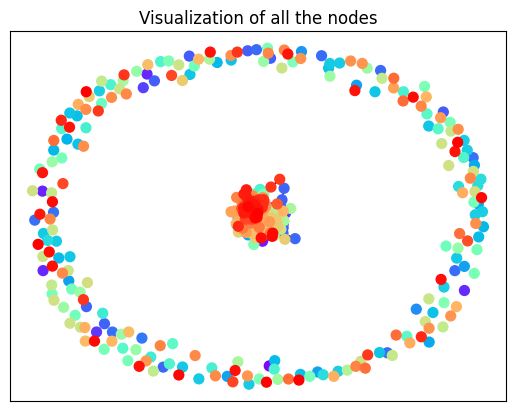

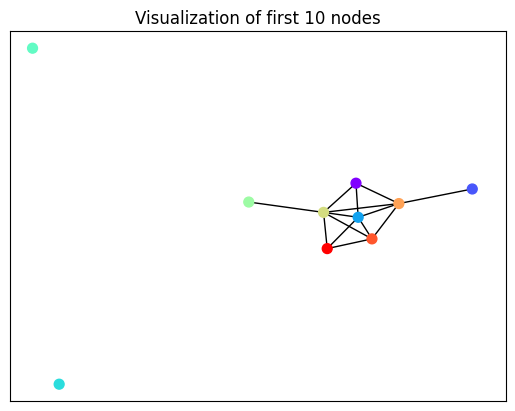

In [3]:
from torch_geometric.utils import to_networkx
def visualize_graph(graph, color, title):
    plt.figure()
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(graph, with_labels=False, node_size=50,
                     node_color=color, cmap="rainbow") #pos=nx.spring_layout(graph, seed=42), 
    plt.title(title)
    plt.show()

# visualize the whole 
G = to_networkx(data, to_undirected=True) # convert the graph object to networkx graph object so that we can visualize them
visualize_graph(G, color=range(1000), title='Visualization of all the nodes')

# taking only the first 10 nodes of the 1000 nodes to visualize
node_indices = list(range(10))
subgraph = G.subgraph(node_indices).copy() # take a subgraph of the graph object
visualize_graph(subgraph, color=range(10), title='Visualization of first 10 nodes')

We can visualize the adjacency matrix of the graph.

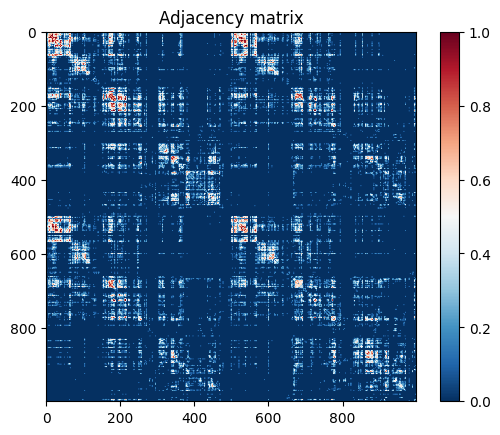

In [4]:

def get_adj_matrix_from_edges(edge_index): # Example edge index (2xE tensor where E is the number of edges)
    # Define the number of nodes
    num_nodes = edge_index.max().item() + 1

    # Create an adjacency matrix from edge_index
    adj_matrix = torch.zeros((num_nodes, num_nodes))
    
    # row: target node, column: source node
    adj_matrix[edge_index[1], edge_index[0]] = 1

    # visualize
    plt.imshow(adj_matrix, cmap='RdBu_r')
    plt.colorbar()
    plt.title('Adjacency matrix')
    plt.show()

get_adj_matrix_from_edges(dataset[0].edge_index)

## Define the Message Passing mechanisms


PyG provides the `MessagePassing` base class to implement a message passing scheme. Recall in the class that we use $$\mathbf{h}_i^{(𝑘+1)}=\text{UPDATE}^{(𝑘)}( \mathbf{h}_𝑖^{(𝑘)}, \text{AGGR}^{(𝑘)}(\{\mathbf{m}_𝑗^{(𝑘)},\forall 𝑗 \in N(i)\}))$$ to define a message passing scheme. 

- **Message computation** (the computation of $\mathbf{m}_j^{(𝑘)}$): `MessagePassing.message(...)`, which constructs message of node $j$ to node $i$. Note that the function header can be `MessagePassing.message(x_j)`, which only computes message from $x_j$, or `MessagePassing.message(x_j, x_i)`, which computes message using `x_j` (i.e. $\mathbf{h}_j$) and `x_i` (i.e. $\mathbf{h}_i$).

- **Message aggregation** (the $\text{AGGR}$ function): `MessagePassing.propagate(edge_index, size=None, **kwargs)`, which is the initial call to start propagating messages. The function takes the edge indices and all additional data (eg. `x=x`) to pass on the state of all the nodes (i.e. $\mathbf{h}$), which is needed to construct messages and to update node embeddings. 

- **Update the node embedding** (the $\text{UPDATE}$ function): This is done after calling `MessagePassing.propagate` in the `MessagePassing.forward()` function, the returned value of `MessagePassing.forward()` is the updated node embedding.

We also need to pay attent to the initialization function in the `MessagePassing` base class
- `MessagePassing(aggr="add", flow="source_to_target", node_dim=-2)`: Defines the aggregation scheme to use ("add", "mean" or "max") and the flow direction of message passing (either "source_to_target" or "target_to_source"). Furthermore, the node_dim attribute indicates along which axis to propagate.

For further information, you could refer to the following [tutorial and the relavant APIs](https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_gnn.html).

### Message Passing with a fixed rule

First, we will implement a message passing by making the node to take the sum of the neighbor nodes.

$$\mathbf{x}_i^{(k+1)} = \mathbf{x}_i^{(k)} + \sum_{j \in N(i)} \mathbf{x}_j^{(k)}$$

Note that the adoption of $\mathbf{x}$ (instead of $\mathbf{h}$) follows the function signature in `MessagePassing`.

In [5]:

from torch_geometric.nn import MessagePassing

class MySimpleConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        torch.manual_seed(12345)
        super().__init__(aggr='sum')  # sum aggregation
        # When MySimpleConv gets initialized, the aggregation function has been set to SumAggregation()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1. Compute the message for each nod
        # Step 2. The propagate function will call the aggregate function using the state x
        # and the neighborhood information (edge_index) 
        # Step 3. The aggregate function has already been predefined to sum aggregation (aggr='sum' in the __init__ function)
        # Step 4. The incoming message after aggregation from all of the neighbors
        incoming = self.propagate(edge_index, x=x) 

        # Step 6. Update the state of the node
        ###################insert your code here ################
        #
        x = incoming + x
        ###################################################

        return x
    
    def message(self, x_j):
        # Step 5. Use this function to compute the message of the each node
        return x_j


In [6]:
from torch_geometric.data import Data

data = Data(x=torch.tensor([[100.,], [200.,], [300.,]]), edge_index=torch.tensor([[0,1],[0,2]]).T)

conv = MySimpleConv(1,1)

x = data.x
edge_index = data.edge_index
x = conv(x, edge_index)
assert x[0] == 100 
assert x[1] == 300
assert x[2] == 400 

# next step
x = conv(x, edge_index)
assert x[0] == 100 
assert x[1] == 400
assert x[2] == 500 
print('Correct!')

Correct!


Next, we will implement the message passing mechanism by making the node to take the sum of a double of neighbor nodes.

$$\mathbf{x}_i^{(k+1)} = \mathbf{x}_i^{(k)} + \sum_{j \in N(i)} 2\mathbf{x}_j^{(k)}$$


Note that the adoption of $\mathbf{x}$ (instead of $\mathbf{h}$) follows the function signature in `MessagePassing`.

In [7]:
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class MySimpleConv2(MessagePassing):
    def __init__(self, in_channels, out_channels):
        torch.manual_seed(12345)
        super().__init__(aggr='sum')  # "Sum" aggregation (Step 5).


    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        
        # Step 1. Compute the message for each nod
        # Step 2. The propagate function will call the aggregate function using the state x
        # and the neighborhood information (edge_index) 
        # Step 3. The aggregate function has already been predefined to sum aggregation (aggr='sum' in the __init__ function)
        # Step 4. The incoming message after aggregation from all of the neighbors
        incoming = self.propagate(edge_index, x=x)

        # Step 6. Update the state of the node
        ########### insert your code #######
        # Compute the update state using incoming and x
        x = incoming + x
        ####################################

        return x


    def message(self, x_j):
        # Step 5. Use this function to compute the message of the each node

        ########### insert your code #######
        # Note that the message of this rule is m_j = 2 * x_j
        # return the computed message 
        return 2 * x_j
        ####################################


In [8]:
from torch_geometric.data import Data

data = Data(x=torch.tensor([[100.,], [200.,], [300.,]]), edge_index=torch.tensor([[0,1],[0,2]]).T)

conv = MySimpleConv2(1,1)

x = data.x
edge_index = data.edge_index
x = conv(x, edge_index)
print(x)
assert x[0] == 100 
assert x[1] == 400
assert x[2] == 500 

# next step
x = conv(x, edge_index)
assert x[0] == 100 
assert x[1] == 600
assert x[2] == 700 
print('Correct!')

tensor([[100.],
        [400.],
        [500.]])
Correct!


### Message Passing with learnable parameters

Now, we will implement `EdgeConv` and `DynamicEdgeConv`.

#### EdgeConv

$$\mathbf{x}_i^{(k+1)} = \text{ReLU}(\sum_{j \in N(i)} \text{MLP}_\Theta(\mathbf{x}_i^{(k)} || \mathbf{x}_j^{(k)} - \mathbf{x}_i^{(k)}))$$


Note that the adoption of $\mathbf{x}$ (instead of $\mathbf{h}$) follows the function signature in `MessagePassing`.

In [9]:
import torch
from torch.nn import Sequential as Seq, Linear, ReLU
from torch_geometric.nn import MessagePassing

class MyEdgeConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='sum') #  "Sum" aggregation.

        # Define the MLP that nonlinearly transforms 2 * in_channels to out_channels
        self.mlp = Seq(Linear(2 * in_channels, out_channels),
                       ReLU(),
                       Linear(out_channels, out_channels))

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1. Compute the message for each nod
        # Step 2. The propagate function will call the aggregate function using the state x
        # and the neighborhood information (edge_index) 
        # Step 3. The aggregate function has already been predefined to sum aggregation (aggr='sum' in the __init__ function)
        # Step 4. The incoming message after aggregation from all of the neighbors
        incoming = self.propagate(edge_index, x=x)

        # Step 6. Apply ReLU to add nonlinearity
        incoming = incoming.relu()

        # Step 7. Update the state of the node
        return incoming

    def message(self, x_i, x_j):
        # Step 5. Using this function computes the message of the each node
        # target node x_i has shape [E, in_channels]
        # source node x_j has shape [E, in_channels]

        ########### insert your code ##########
        # Note that in EdgeConv, 
        # you will compute the message using both x_i and x_j, 
        # as well as an MLP (see self.mlp(tmp))
        # tip: you can use torch.cat(tensors, dim=1) to concatenante torch arrays at dim=1
        tmp = torch.cat([x_i, x_j - x_i], dim=1) 
        #######################################

        return self.mlp(tmp)
        

#### DynamicEdgeConv

Instead of using a fixed `edge_index`, we can also compute `edge_index` dynamically from the node embedding every time we do message passing.

In [10]:
from torch_geometric.nn import knn_graph

class MyDynamicEdgeConv(MyEdgeConv): 
    # this class extends MyEdgeConv, 
    # so we just need to implement MyDynamicEdgeConv.forward(...)
    # and MyDynamicEdgeConv.message(self, x_i, x_j) is the same
    def __init__(self, in_channels, out_channels, k=6):
        super().__init__(in_channels, out_channels)
        self.k = k

    def forward(self, x, batch=None):

        # dynamically compute the edge indices from the data x
        edge_index = knn_graph(x, self.k, batch, loop=False, flow=self.flow)

        # call the forward function in MyEdgeConv
        return super().forward(x, edge_index)

#### Our first GNN model using DynamicEdgeConv

Let's put Learnable Message Passing together!

Our First GNN consists of two `MyDynamicEdgeConv` layers with a `ReLu` non-linear activation layer in between, which results in learned node embeddings. Then, we uses `global_mean_pool` to perform mean pooling of all the nodes in each graph to get the graph embedding for each graph, and connects with a fully connected layer for final output.

In [11]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool


class MyFirstGNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MyFirstGNN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = MyDynamicEdgeConv(dataset.num_node_features, hidden_channels)
        self.conv2 = MyDynamicEdgeConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, batch):

        # 1. Obtain node embeddings     
        x = self.conv1(x, batch)

        ########### insert your code  ##########
        # Take x through self.conv2
        x = self.conv2(x, batch)
        #######################################
        
        # 2. Readout layer that takes mean pooling
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = MyFirstGNN(hidden_channels=64)
print(model)


MyFirstGNN(
  (conv1): MyDynamicEdgeConv()
  (conv2): MyDynamicEdgeConv()
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


## Finally, training and testing model on the data

### Load training and testing datasets

In [12]:
# Train/test split (80-20)
train_share = int(len(dataset) * 0.8)

train_dataset = dataset[:train_share]
test_dataset = dataset[train_share:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 862
Number of test graphs: 216


We can use `torch_geometric.loader.DataLoader` to load the graph in batch, similar to DataLoader in `pytorch`.

In [13]:
from torch_geometric.loader import DataLoader

# torch.geometric provide similar infrastructure as torch, including data loader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

for step, batch_data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {batch_data.num_graphs}')
    print(batch_data)
    break

Step 1:
Number of graphs in the current batch: 16
DataBatch(x=[16000, 1000], edge_index=[2, 697964], y=[16], batch=[16000], ptr=[17])


### Device

In [14]:
# get the device depending on GPU cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Training and testing

Now let's run the training and testing pipeline, and you should get near or above 85% test accuracy in your best epoch, after training for 20 epochs.

In [15]:
from tqdm.notebook import tqdm

model = MyFirstGNN(hidden_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

def train(loader):
    model.train()

    all_loss = 0
    correct = 0
    for data in tqdm(loader, desc="train"):  # Iterate in batches over the training dataset.
        data = data.to(device)
        
        # Perform a single forward pass.
        out = model(data.x, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        
        # Check against ground-truth labels.
        correct += int((pred == data.y).sum())  

        ############ insert your code (3 lines) ###############
        # Compute the loss. You can obtain the label using data.y
        loss = criterion(out, data.y)

        # Perform backward propagation 
        loss.backward()  

        # Update parameters based on gradients.
        optimizer.step()  
        
        #######################################################

        optimizer.zero_grad()  # Clear gradients.
        
        all_loss += loss.item() * data.num_graphs 
    return  all_loss / len(train_loader), correct / len(loader.dataset) 


def test(loader):
    model.eval()

    correct = 0
    for data in tqdm(loader, desc="test"):  # Iterate in batches over the training/test dataset.
        data = data.to(device)
        out = model(data.x, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 20):
    train_loss, train_acc = train(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

train:   0%|          | 0/54 [00:00<?, ?it/s]

test:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 001, Train loss: 11.0956, Train Acc: 0.5580, Test Acc: 0.5972


train:   0%|          | 0/54 [00:00<?, ?it/s]

test:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 002, Train loss: 10.6144, Train Acc: 0.5940, Test Acc: 0.6157


train:   0%|          | 0/54 [00:00<?, ?it/s]

test:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 003, Train loss: 10.5042, Train Acc: 0.6056, Test Acc: 0.5417


train:   0%|          | 0/54 [00:00<?, ?it/s]

test:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 004, Train loss: 9.9302, Train Acc: 0.6450, Test Acc: 0.6574


train:   0%|          | 0/54 [00:00<?, ?it/s]

test:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 005, Train loss: 8.6423, Train Acc: 0.7251, Test Acc: 0.7176


train:   0%|          | 0/54 [00:00<?, ?it/s]

test:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 006, Train loss: 7.7806, Train Acc: 0.7738, Test Acc: 0.8102


train:   0%|          | 0/54 [00:00<?, ?it/s]

test:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 007, Train loss: 7.3413, Train Acc: 0.7738, Test Acc: 0.7778


train:   0%|          | 0/54 [00:00<?, ?it/s]

test:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 008, Train loss: 4.9984, Train Acc: 0.8805, Test Acc: 0.8241


train:   0%|          | 0/54 [00:00<?, ?it/s]

test:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 009, Train loss: 3.8596, Train Acc: 0.9130, Test Acc: 0.8472


train:   0%|          | 0/54 [00:00<?, ?it/s]

test:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 010, Train loss: 4.3565, Train Acc: 0.8875, Test Acc: 0.7546


train:   0%|          | 0/54 [00:00<?, ?it/s]

test:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 011, Train loss: 3.1999, Train Acc: 0.9211, Test Acc: 0.8843


train:   0%|          | 0/54 [00:00<?, ?it/s]

test:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 012, Train loss: 1.8323, Train Acc: 0.9582, Test Acc: 0.8148


train:   0%|          | 0/54 [00:00<?, ?it/s]

test:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 013, Train loss: 2.0657, Train Acc: 0.9652, Test Acc: 0.8426


train:   0%|          | 0/54 [00:00<?, ?it/s]

test:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 014, Train loss: 1.8868, Train Acc: 0.9594, Test Acc: 0.7130


train:   0%|          | 0/54 [00:00<?, ?it/s]

test:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 015, Train loss: 2.2379, Train Acc: 0.9478, Test Acc: 0.8889


train:   0%|          | 0/54 [00:00<?, ?it/s]

test:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 016, Train loss: 1.8656, Train Acc: 0.9617, Test Acc: 0.8611


train:   0%|          | 0/54 [00:00<?, ?it/s]

test:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 017, Train loss: 0.8770, Train Acc: 0.9791, Test Acc: 0.8565


train:   0%|          | 0/54 [00:00<?, ?it/s]

test:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 018, Train loss: 0.6089, Train Acc: 0.9896, Test Acc: 0.8935


train:   0%|          | 0/54 [00:00<?, ?it/s]

test:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 019, Train loss: 0.6599, Train Acc: 0.9849, Test Acc: 0.8380
